# 丢弃法

动机
- 一个好的模型需要对输入数据扰动鲁棒
  - 使用有噪音的数据等价于Tikhonov正则
  - 丢弃法：在层之间加入噪音

无偏差的加入噪音
- 对x加入噪音得到x',我们希望E[x'] = x
- 丢弃法对每个元素进行如下扰动
  
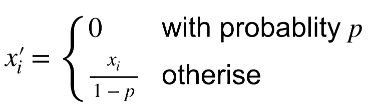

使用丢弃法
- 通常将丢弃法作用在隐藏全连接层的输出上

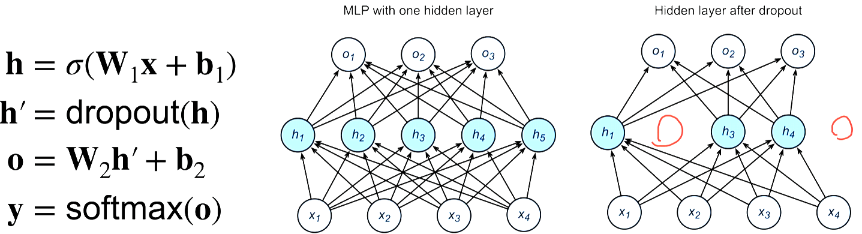

推理中的丢弃法
- 正则项只在训练中使用：他们影响模型参数的更新，在测试时不需要进行该操作
- 在推理过程中，丢弃法直接返回输入
  h' = dropout(h)
- 这样也能保证稳定的输出

总结
- 丢弃法将一些输出项随机置0来控制模型复杂度
- 常作用在多层感知机的隐藏层输出上
- 丢弃概率时控制模型复杂度的超参数

In [1]:
#导入第三方库
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#手动实现dropout_layer
#该函数以dropout的概率丢弃张量输入X中的元素，重新缩放剩余部分：将剩余部分除以1.0-dropout
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    #丢弃所有元素
    if dropout == 1:
        return torch.zeros_like(X)
    #不执行丢弃
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [3]:
#测试dropout函数
X = torch.arange(16, dtype= torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.0))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8.,  0., 12., 14.],
        [16., 18.,  0., 22.,  0., 26.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [4]:
#定义模型参数
num_inputs, num_outputs, num_hidden1, num_hidden2 = 28*28, 10, 256, 256
#定义模型
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2,
                 is_training= True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()  
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        #只有在训练模型时使用dropout
        if self.training == True:
            #在第一个全连接层之后添加dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            #在第二个全连接层之后添加dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

In [5]:
net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

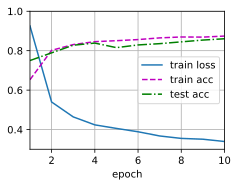

In [6]:
#训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction= 'none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
#定义优化器
trainer = torch.optim.SGD(net.parameters(), lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [8]:
#丢弃法的简洁实现
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    #在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    #在第二个全连接层之后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std= 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=10, bias=True)
)

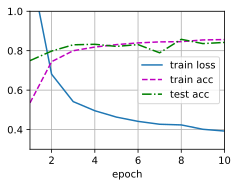

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)